### 0. Import Packages

In [1]:
import time
import serial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Declare COM ports for Serial Communication (RS-232)

* **Balance:** Mettler Toledo MR3002
* **Pump**: Ismatec Reglo ICC 4-channel, 8-roller peristaltic pump

In [ ]:
balance_port = 'COM8'
pump_port = 'COM9'

### 2. Balance Control

In [ ]:
def get_mass(port):
    try:
        balance = serial.Serial(port, 9600, xonxoff=True) # check COM port and xonxoff (handshake) = True default for MT balance
        balance.write('SI\r\n'.encode('utf-8')) # sent immediate weight vs. 'S\r\n' send stable weight only
        time.sleep(0.4) # sleep for 0.4 seconds - time between writing and reading from balance
        result  = balance.read_until('\r\n'.encode('utf-8')) # read until <CR><LF>, i.e., full response
        value = str(result[7:14].decode("utf-8")) # strip numerical result from raw output
        balance.close()
        if (value.strip() != '-------') and (value.strip() != ''):
            return (True,float(value)) # return a status T vs. F, in addition to the mass reading - useful for future steps (data logging)
        return (False,-1)
    except:
        return (False,-1)

### 3. Pump Control

In [4]:
from PeriPump import RegloICC
pump = RegloICC(pump_port) # initialise pump 

The available functions from the pump class are `start_channel`, `stop_channel`, `set_direction`, `get_direction`, `set_speed`, `get_speed`, `set_mode` ,`get_mode`.

In [ ]:
# Example pump commands

# ### Set the rotation direction of channel 3 to clockwise
# pump.set_direction(3, 0)

# ### Get the rotation direction of channel 3
# print(pump.get_direction(3))

# ### Set the operational mode of channel 3 to RPM
# pump.set_mode(3, 0)

# ### Get the current operational mode of channel 3
# print(pump.get_mode(3))


# ### Get the current speed setting of channel 3
# print(pump.get_speed(3))

### Set the independent channel speeds
# pump.set_speed(1, 50)
# pump.set_speed(2, 100) # max speed 100 RPM
# pump.set_speed(3, 100) # max speed 100 RPM
# pump.set_speed(4, 50)

# pump.start_channel(1)
# pump.start_channel(2)
# pump.start_channel(3)
# pump.start_channel(4)

# ### Stop channel 3
# pump.stop_channel(3)

# ### Delete the pump object
# del pump

### 4. AutoDose Programme

In [17]:
# Map ingredients to pump channels

pump_dict = {'SLES':1,
            'CAPB': 2, 
            'Water': 3,
            None:4}

In [8]:
def dose_ingredient(ing, amt, balance_port, pump_speed=100):
    '''
    Insert doc string. 
    '''
    t = [0]  # time 
    m = [get_mass(balance_port)[1]] # mass - initialise with initial mass
    # NB. get_mass returns tuple (STATUS, MASS), therefore, [1] to access mass value.

    i = 0 # initialise counter

    channel = pump_dict[ing]
    pump.set_speed(channel, pump_speed) # max speed = 100 RPM

    while m[-1] < m[0] + amt:

        # Turn on and keep the pump going till the target amount is reached.
        
        pump.start_channel(channel)

        status, val = get_mass(balance_port)
        if status:
            curr_val = val
        else:
            curr_val = m[-1] 
        m.append(curr_val)

        i += 1
        t.append(i*0.5) # 0.4 s sleep time between reading & writing to balance + 0.1 s execution lag
        # NB. Therefore, mass is recorded every 0.5 seconds.

    pump.stop_channel(channel)

    disp_m = m[-1] - m[0]
    acc = np.round((np.absolute(disp_m - amt)/amt)*100,2)

    return np.round(disp_m,2), acc, m, t

In [18]:
disp_m, acc, m, t = dose_ingredient('SLES', 5, balance_port)
print(disp_m, acc)

5.03 0.6


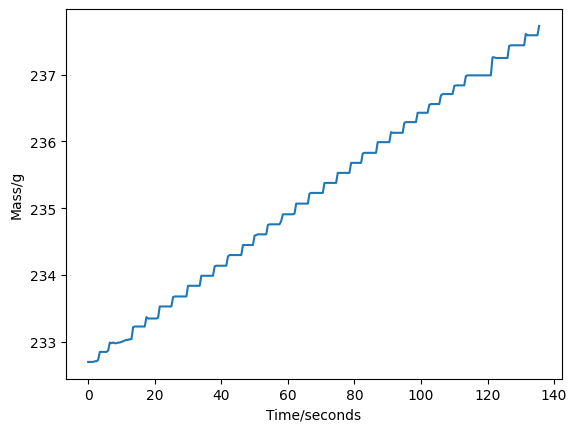

In [19]:
plt.plot(t, m);
plt.xlabel('Time/seconds');
plt.ylabel('Mass/g');

#### Limitations

* Speed/time to dispense viscous ingredients.
* Cleaning of lines - recommend not changing lines on core viscous materials or replacing tubing as required.